## Test notebook for Data Management Acceptance Test Campaign 1
This test will be executed on the Rubin Science Platform Notebook Aspect at the Interim Data Facility, initialized with Science Pipelines release w_2022_32.

### Test case LVV-T42: Verify implementation of Processed Visit Image Content

Verify that Processed Visit Images produced by the DRP and AP pipelines include the observed data, a mask array, a variance array, a PSF model, and a WCS model.

In [1]:
from lsst.daf.butler import Butler

import matplotlib.pyplot as plt
import numpy as np
import os
import lsst.afw.display as afwDisplay

from firefly_client import FireflyClient

#### Initialize the butler pointing to DP0.2 data:

In [2]:
# For DP0.2 data on the IDF:                                                                                                           
config = 'dp02'
collection = '2.2i/runs/DP0.2'
butler = Butler(config, collections=collection)

#### Select a single PVI (aka "calexp") and associated source catalog for examination

In [3]:
dataId = {'instrument': 'LSSTCam-imSim', 'detector': 78, 'visit': 60891, 'exposure':60891, 'band':'i'}

In [4]:
# extract the WCS object, calexp image, psf model, and source list
calexp = butler.get('calexp', dataId=dataId)
src = butler.get('src', dataId=dataId)

psf = calexp.getPsf()
wcs = calexp.getWcs()

#### Examine the image to confirm that it has well-formed variance and mask planes, in addition to the calexp image.

In [5]:
afwDisplay.setDefaultBackend('firefly')
afw_display = afwDisplay.Display(frame=1)

# Set up some plotting defaults:

params = {'axes.labelsize': 28,
          'font.size': 24,
          'legend.fontsize': 14,
          'xtick.major.width': 3,
          'xtick.minor.width': 2,
          'xtick.major.size': 12,
          'xtick.minor.size': 6,
          'xtick.direction': 'in',
          'xtick.top': True,
          'lines.linewidth': 3,
          'axes.linewidth': 3,
          'axes.labelweight': 3,
          'axes.titleweight': 3,
          'ytick.major.width': 3,
          'ytick.minor.width': 2,
          'ytick.major.size': 12,
          'ytick.minor.size': 6,
          'ytick.direction': 'in',
          'ytick.right': True,
          'figure.figsize': [7, 7],
          'figure.facecolor': 'White'
          }

plt.rcParams.update(params)

In [6]:
# This opens the calexp in Firefly, where we will examine it:
afw_display.mtv(calexp)

In [7]:
afw_display2 = afwDisplay.Display(frame=2)
afw_display2.mtv(calexp.variance)

#### Extract some statistics from the images:

In [8]:
print('  image           median     stddev    (of image pixel values)')
print('calexp:           ', np.nanmedian(calexp.image.array), np.nanstd(calexp.image.array))
print('variance:         ', np.nanmedian(calexp.variance.array), np.nanstd(calexp.variance.array))

  image           median     stddev    (of image pixel values)
calexp:            1.298006 442.78458
variance:          5865.997 649.1014


These are as expected -- the calexp is sky-subtracted, so it has roughly zero median flux.

#### Inspect the PSF and confirm that it varies with position:

In [9]:
import lsst.geom as geom

pos1 = geom.Point2D(134.0, 1043.6)
psf1 = psf.computeImage(pos1)

pos2 = geom.Point2D(502.7, 96.2)
psf2 = psf.computeImage(pos2)

In [10]:
psf1minus2_img = psf1.clone()
psf1minus2_img -= psf2

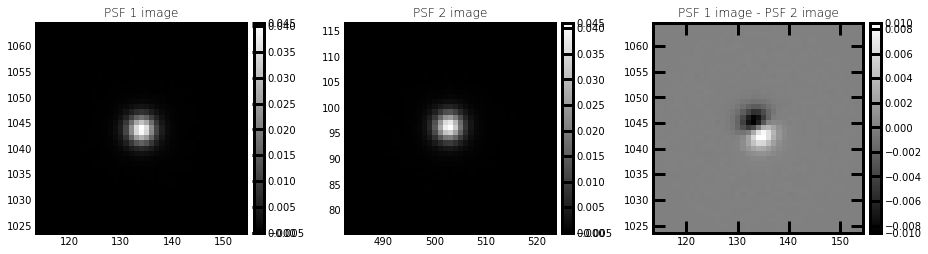

In [11]:
afwDisplay.setDefaultBackend('matplotlib')

fig, ax = plt.subplots(1, 3, figsize=(13, 7))

plt.sca(ax[0])
display0 = afwDisplay.Display(frame=fig)
display0.scale("linear", "minmax")
display0.mtv(psf1)
plt.title("PSF 1 image")

plt.sca(ax[1])
display0 = afwDisplay.Display(frame=fig)
display0.scale("linear", "minmax")
display0.mtv(psf2)
plt.title("PSF 2 image")

plt.sca(ax[2])
display0 = afwDisplay.Display(frame=fig)
display0.scale("linear", "minmax")
display0.mtv(psf1minus2_img)
plt.title("PSF 1 image - PSF 2 image")

plt.tight_layout()
plt.show()

#### Pick a source and confirm that conversions between XY and RA, Dec coordinates using the WCS object give values that match the catalog values. 

In [12]:
cat_ind = 143

x = src[cat_ind]['base_SdssCentroid_x']
y = src[cat_ind]['base_SdssCentroid_y']

ra = src[cat_ind]['coord_ra']
dec = src[cat_ind]['coord_dec']

print('(X, Y): (', x, ', ', y, ')')
print('(ra, dec): (', ra.asDegrees(), ', ', dec.asDegrees(), ')')


(X, Y): ( 1730.342687466467 ,  386.1185560155262 )
(ra, dec): ( 71.89388932338906 ,  -37.34102758827357 )


In [13]:
print('RA, Dec from X, Y: ', wcs.pixelToSky(x, y))

print('X, Y from RA, Dec: ', wcs.skyToPixel(geom.SpherePoint(ra, dec)))

# Use asserts to confirm the values are equal:
assert(np.allclose(wcs.skyToPixel(geom.SpherePoint(ra, dec)).x, x))
assert(np.allclose(wcs.skyToPixel(geom.SpherePoint(ra, dec)).y, y))
print('Sky to pixel agrees!')

RA, Dec from X, Y:  (71.8938893234, -37.3410275883)
X, Y from RA, Dec:  (1730.3, 386.12)
Sky to pixel agrees!


### Now repeat the same steps for a difference image

In [14]:
diffim = butler.get('goodSeeingDiff_differenceExp', dataId=dataId)
diasrc = butler.get('goodSeeingDiff_diaSrc', dataId=dataId)

psf = calexp.getPsf()
wcs = calexp.getWcs()

In [15]:
afwDisplay.setDefaultBackend('firefly')
afw_display = afwDisplay.Display(frame=1)

In [16]:
# This opens the calexp in Firefly, where we will examine it:
afw_display.mtv(diffim)

#### Extract some statistics from the images:

In [17]:
print('  image           median     stddev    (of image pixel values)')
print('diffim:           ', np.nanmedian(diffim.image.array), np.nanstd(diffim.image.array))
print('variance:         ', np.nanmedian(diffim.variance.array), np.nanstd(diffim.variance.array))

  image           median     stddev    (of image pixel values)
diffim:            -0.058853626 181.63496
variance:          5900.847 nan


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')


#### Inspect the PSF and confirm that it varies with position:

In [18]:
pos1 = geom.Point2D(134.0, 1043.6)
psf1 = psf.computeImage(pos1)

pos2 = geom.Point2D(502.7, 96.2)
psf2 = psf.computeImage(pos2)

psf1minus2_img = psf1.clone()
psf1minus2_img -= psf2


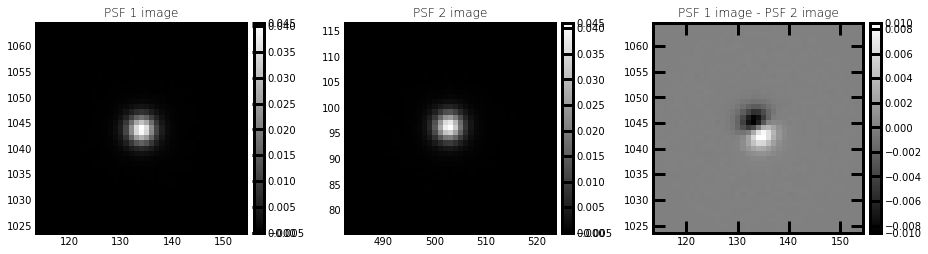

In [19]:
afwDisplay.setDefaultBackend('matplotlib')

fig, ax = plt.subplots(1, 3, figsize=(13, 7))

plt.sca(ax[0])
display0 = afwDisplay.Display(frame=fig)
display0.scale("linear", "minmax")
display0.mtv(psf1)
plt.title("PSF 1 image")

plt.sca(ax[1])
display0 = afwDisplay.Display(frame=fig)
display0.scale("linear", "minmax")
display0.mtv(psf2)
plt.title("PSF 2 image")

plt.sca(ax[2])
display0 = afwDisplay.Display(frame=fig)
display0.scale("linear", "minmax")
display0.mtv(psf1minus2_img)
plt.title("PSF 1 image - PSF 2 image")

plt.tight_layout()
plt.show()

#### Pick a source and confirm that conversions between XY and RA, Dec coordinates using the WCS object give values that match the catalog values. 

In [20]:
cat_ind = 43

x = diasrc[cat_ind]['base_SdssCentroid_x']
y = diasrc[cat_ind]['base_SdssCentroid_y']

ra = diasrc[cat_ind]['coord_ra']
dec = diasrc[cat_ind]['coord_dec']

print('(X, Y): (', x, ', ', y, ')')
print('(ra, dec): (', ra.asDegrees(), ', ', dec.asDegrees(), ')')

(X, Y): ( 2428.1824022462747 ,  2730.042250592946 )
(ra, dec): ( 71.77813917941924 ,  -37.44087706845673 )


In [21]:
print('RA, Dec from X, Y: ', wcs.pixelToSky(x, y))

print('X, Y from RA, Dec: ', wcs.skyToPixel(geom.SpherePoint(ra, dec)))

# Use asserts to confirm the values are equal:
assert(np.allclose(wcs.skyToPixel(geom.SpherePoint(ra, dec)).x, x))
assert(np.allclose(wcs.skyToPixel(geom.SpherePoint(ra, dec)).y, y))
print('Sky to pixel agrees!')

RA, Dec from X, Y:  (71.7781391794, -37.4408770685)
X, Y from RA, Dec:  (2428.2, 2730)
Sky to pixel agrees!


We have now verified that all the expected data and attributes are present in PVIs.